In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random as random
%matplotlib inline
from casadi import *

# Puydupin


In [2]:
n = 25
taux = 1/n

In [3]:
x1i = SX.sym('x1i',1)                   
x2i = SX.sym('x2i',1)                
x3i = SX.sym('x3i',1)


x1f = SX.sym('x1f',1)
x2f = SX.sym('x2f',1)
x3f = SX.sym('x3f',1)


c1 = SX.sym('c1',1)
c2 = SX.sym('c2',1)

u1=SX.sym('u1',n)  

u2=SX.sym('u2',n)  

x1=SX.sym('x1',n)

x2=SX.sym('x2',n)

x3=SX.sym('x3',n)

Lambda = SX.sym('Lambda',3*(n+1))

In [4]:
F = SX.sym('F',2)

F[0] = (taux/2)*dot(u1,u1)
F[1] = (taux/2)*dot(u2,u2)

G = SX.sym('G',3*(n+1))

G[0] = x1[0] - x1i
G[1] = x2[0] - x2i
G[2] = x3[0] - x3i

for i in range (1,n) :
    G[3*i] = x1[i-1] + taux * u1[i-1] * cos(x3[i-1]) - x1[i]
    G[3*i+1] = x2[i-1] + taux * u1[i-1] * sin(x3[i-1]) - x2[i]
    G[3*i+2] = x3[i-1] + taux * u2[i-1]  - x3[i]
    
G [3*(n+1)-3] = x1[-1] - x1f
G [3*(n+1)-2] = x2[-1] - x2f
G [3*(n+1)-1] = x3[-1] - x3f


## contrainte d'inégalite
H = SX.sym('H',4 )

H [0] =  u1[0] -0.0001 
H [1] =  u2[0] -0.0001
H [2] =  u1[-1] - 0.0001
H [3] =  u2[-1] - 0.0001

G0 = vertcat(G,H)
F_G = vertcat(F , G, H)
X = vertcat(u1,u2,x1,x2,x3)


In [5]:
J = SX.zeros(5*n, F_G.shape[0])
J_w = SX.zeros(X.shape[0],F.shape[0])
J_lambda = SX.zeros(X.shape[0],G0.shape[0])

In [6]:
for i in range (X.shape[0]):
    for j in range (F_G.shape[0]) :
        J[i,j] = jacobian(F_G[j], X[i])
        
for i in range (X.shape[0]):
    for j in range (F.shape[0]) :
        J_w[i,j] = jacobian(F[j], X[i])
        
for i in range (X.shape[0]):
    for j in range (G0.shape[0]) :
        J_lambda[i,j] = jacobian(G0[j], X[i])
        
        
Jacobienne = Function ('Jacobienne', [u1,u2,x1,x2,x3], [J])
Jacobienne_w1 = Function ('Jacobienne_w1', [u1,u2,x1,x2,x3], [J_w])
Jacobienne_lambda1 = Function ('Jacobienne_lambda1', [u1,u2,x1,x2,x3], [J_lambda])

In [7]:
x=SX.sym('x',n)
f= Function('f',[x],[x[1:]])

In [8]:
def Unicycle_DOC (f, Xi , Xf , c1 , c2) :
    x1i = Xi[0] 
    x2i = Xi[1]
    x3i = Xi[2]
    
    x1f = Xf[0] 
    x2f = Xf[1]
    x3f = Xf[2]
    
    opti = casadi.Opti()   # cette fonction nous permet de trouver la solution de problème

    u1 = opti.variable(n)
    u2 = opti.variable(n)
    x1 = opti.variable(n)
    x2 = opti.variable(n)
    x3 = opti.variable(n)

    opti.minimize(   (taux/2)*(c1*dot(u1,u1)+c2*dot(u2,u2))   )    # ma fonction objetion

    # mes fonctions de contrainte d'égalité:

    ## pour les condition initial
    opti.subject_to( x1[0]==x1i)        
    opti.subject_to( x2[0]==x2i)
    opti.subject_to( x3[0]==x3i)

    opti.subject_to( u1[0] == 0.0001 )
    opti.subject_to( u2[0] == 0.0001 )
    opti.subject_to( u1[-1] == 0.0001)
    opti.subject_to( u2[-1] == 0.0001)

    ## pour les contraintes d'égaliter
    opti.subject_to( x1[:n-1]+taux*u1[:n-1]*cos(x3[:n-1])==f(x1) )
    opti.subject_to( x2[:n-1]+taux*u1[:n-1]*sin(x3[:n-1])==f(x2) )
    opti.subject_to( x3[:n-1]+taux*u2[:n-1] ==f(x3))

    ## pour les conditions finales
    opti.subject_to( x1[-1]==x1f)
    opti.subject_to( x2[-1]==x2f)
    opti.subject_to( x3[-1]==x3f)


    opti.solver('ipopt')      # suivant la méthode de KKT


    sol = opti.solve()
    
    X1 = sol.value(x1)
    X2 = sol.value(x2)
    X3 = sol.value(x3)
    
    U1 = sol.value(u1)
    U2 = sol.value(u2)
    
    return X1,X2,X3,U1,U2

In [9]:
c1 = 0.1                 # suivant l'article  on va essayé de le retrouver
c2 = 0.9

x1i = -4                   # condition initiale de x1
x2i = -3                 # condition initiale de x2
x3i = -pi              # condition initiale de x3


x1f = 0            # condition final de x1
x2f = 0            # condition final de x2
x3f = pi/2         # condition final de x3

Xi = [x1i,x2i,x3i]
Xf = [x1f,x2f,x3f]

X1,X2,X3,U1,U2 = Unicycle_DOC (f, Xi , Xf , c1 , c2)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:      274
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       98

Total number of variables............................:      125
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       82
Total number of inequality co

In [10]:
J = Jacobienne(U1,U2,X1,X2,X3)
J_w = Jacobienne_w1 (U1,U2, X1,X2,X3)
J_lambda = Jacobienne_lambda1 (U1,U2, X1,X2,X3)

U, Eps , V = np.linalg.svd(J)

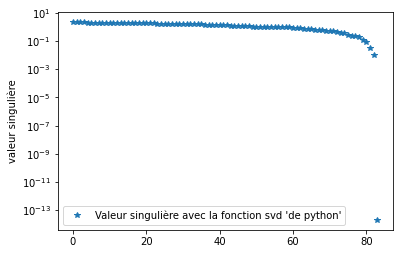

In [11]:
plt.plot(Eps, "*", label = "Valeur singulière avec la fonction svd 'de python'")

plt.ylabel("valeur singulière")
plt.yscale('log')
plt.legend()

In [12]:
print("The rank of the matrice J_w is : ", np.linalg.matrix_rank(J_w) , "and his dimension is : ", J_w.shape)
print("The rank of the matrice J_lambda is  : ", np.linalg.matrix_rank(J_lambda) , "and his dimension is : ", J_lambda.shape)
print("The rank of the matrice J is : ", np.linalg.matrix_rank(J) , "and his dimension is : ", J.shape)


The rank of the matrice J_w is :  2 and his dimension is :  (125, 2)
The rank of the matrice J_lambda is  :  82 and his dimension is :  (125, 82)
The rank of the matrice J is :  83 and his dimension is :  (125, 84)


# Katja_MOMBAUR

In [13]:
T = 5
taux = T/n

In [14]:
xi = SX.sym('xi',1)                   
yi = SX.sym('yi',1)                
thetai = SX.sym('thetai',1)


xf = SX.sym('xf',1)
yf = SX.sym('yf',1)
thetaf = SX.sym('thetaf',1)

alpha1 = SX.sym('alpha1',1)
alpha2 = SX.sym('alpha2',1)
alpha3 = SX.sym('alpha3',1)

## Position
x=SX.sym('x',n)

y=SX.sym('y',n)

theta=SX.sym('theta',n)

## Vitesse
v1=SX.sym('v1',n)  

v2=SX.sym('v2',n)  

w=SX.sym('w',n)

## accélération 
u1 = SX.sym('u1',n)
u2 = SX.sym('u2',n)
u3 = SX.sym('u3',n)


Lambda = SX.sym('Lambda',6*(n))

In [36]:
F_K = SX.sym('F_K',3)

F_K[0] = taux*dot(u1,u1)
F_K[1] = taux*dot(u2,u2)
F_K[2] = taux*dot(u3,u3)



G = SX.sym('G',6*(n))

G[0] = x[0] - xi
G[1] = y[0] - yi
G[2] = theta[0] - thetai


for i in range (0,n) :
    G[6*i-3] = x[i-1] + taux * (v1[i-1] * cos(theta[i-1]) - sin(theta[i-1])*v2[i-1])- x[i]
    G[6*i-2] = y[i-1] + taux *(v1[i-1] * sin(theta[i-1]) + cos(theta[i-1])*v2[i-1]) - y[i]
    G[6*i-1] = theta[i-1] + taux * w[i-1]  - theta[i]
    G[6*i] = v1[i-1] + taux * u1[i-1]  - v1[i]
    G[6*i+1] = w[i-1] + taux * u2[i-1]  - w[i]
    G[6*i+2] = v2[i-1] + taux * u3[i-1]  - v2[i]
    
    
G [6*(n)-3] = x[-1] - xf
G [6*(n)-2] = y[-1] - yf
G [6*(n)-1] = theta[-1] - thetaf

H = SX.sym('H',12)

H[0] = v1[0]-0.0001
H[1] = w[0]-0.0001
H[2] = v2[0]-0.0001


H[3] = v1[-1]-0.0001
H[4] = w[-1]-0.0001
H[5] = v2[-1]-0.0001

H[6] = u1[0]-0.0001
H[7] = u2[0]-0.0001
H[8] = u3[0]-0.0001


H[9] = u1[-1]-0.0001
H[10] = u2[-1]-0.0001
H[11] = u3[-1]-0.0001


In [37]:
F_G = vertcat(F_K , G, H)
G1 = vertcat(G,H)
X = vertcat(u1,u2,u3, v1,w,v2,x,y,theta)
J_K = SX.zeros(X.shape[0],F_G.shape[0])
J_w = SX.zeros(X.shape[0],F_K.shape[0])
J_lambda = SX.zeros(X.shape[0],G1.shape[0])


for i in range (X.shape[0]):
    for j in range (F_G.shape[0]) :
        J_K[i,j] = jacobian(F_G[j], X[i])
        
for i in range (X.shape[0]):
    for j in range (F_K.shape[0]) :
        J_w[i,j] = jacobian(F_K[j], X[i])
        
for i in range (X.shape[0]):
    for j in range (G1.shape[0]) :
        J_lambda[i,j] = jacobian(G1[j], X[i])
        

In [38]:
Jacobienne_K = Function ('Jacobienne_K', [u1,u2, u3, v1,w,v2,x,y,theta], [J_K])
Jacobienne_w = Function ('Jacobienne_w', [u1,u2, u3, v1,w,v2,x,y,theta], [J_w])
Jacobienne_lambda = Function ('Jacobienne_lambda', [u1,u2, u3, v1,w,v2,x,y,theta], [J_lambda])


In [43]:
def Katja_Mombaur_DOC ( Xi, Xf, alpha1, alpha2, alpha3):
    xi = Xi[0] 
    yi = Xi[1]
    thetai = Xi[2]
    
    xf = Xf[0] 
    yf = Xf[1]
    thetaf = Xf[2]
    
    opti = casadi.Opti()   # cette fonction nous permet de trouver la solution de problème

    ## les positions
    x = opti.variable(n)
    y = opti.variable(n)
    theta = opti.variable(n)

    ## les vitesses 
    v1 = opti.variable(n)        ## vitesse latérale
    v2 = opti.variable(n)        ## vitesse orthogonal
    w = opti.variable(n)         ## vitesse angulaire
    
        ## les vitesses 
    u1 = opti.variable(n)        ## accélération latérale
    u3 = opti.variable(n)        ## accélération orthogonal
    u2 = opti.variable(n)        ## accélération angulaire
    
    
    
    opti.minimize(  taux*(alpha1 * dot(u1,u1) + alpha2 * dot(u2,u2 ) + alpha3 * dot( u3 ,u3 ) ) )    # ma fonction objetion

    # mes fonctions de contrainte d'égalité:

    ## pour les condition initial
    opti.subject_to( x[0] == xi)        
    opti.subject_to( y[0] == yi)
    opti.subject_to( theta[0] == thetai)

        
    opti.subject_to( v1[0] == 0.0001 )
    opti.subject_to( w[0] == 0.0001 )
    opti.subject_to( v2[0] == 0.0001 )
    opti.subject_to( v1[-1] == 0.0001 )
    opti.subject_to( w[-1] == 0.0001 )
    opti.subject_to( v2[-1] == 0.0001 )

    opti.subject_to( u1[-1] == 0.0001 )
    opti.subject_to( u2[-1] == 0.0001 )
    opti.subject_to( u3[-1] == 0.0001 )

    opti.subject_to( u1[0] == 0.0001 )
    opti.subject_to( u2[0] == 0.0001 )
    opti.subject_to( u3[0] == 0.0001 )



    ## pour les contraintes d'égaliter
    opti.subject_to( x[1:] == x[:n-1]+taux*(cos(theta[:n-1])*v1[:n-1] - sin(theta[:n-1])*v2[:n-1]) )
    opti.subject_to( y[1:] == y[:n-1]+taux*(sin(theta[:n-1])*v1[:n-1] + cos(theta[:n-1])*v2[:n-1]) )
    opti.subject_to( theta[1:] == theta[:n-1] + taux*w[:n-1] )
    opti.subject_to( (v1[:n-1] + taux* u1[:n-1] == v1[1:])  )
    opti.subject_to( (v2[:n-1] + taux* u3[:n-1] == v2[1:]) )
    opti.subject_to( (w[:n-1] + taux* u2[:n-1] == w[1:]) )
    

    ## pour les conditions finales
    opti.subject_to( x[-1]==xf)
    opti.subject_to( y[-1]==yf)
    opti.subject_to( theta[-1]==thetaf)


    opti.solver('ipopt')      # suivant la méthode de KKT


    sol = opti.solve()
    
    
    X = sol.value(x)
    Y = sol.value(y)
    THETA = sol.value(theta)
    
    V1 = sol.value(v1)
    V2 = sol.value(v2)
    W = sol.value(w)
    
    return X,Y,THETA, V1,V2,W, sol.value(u1),sol.value(u2),sol.value(u3)

In [44]:
alpha1 = 0.2
alpha2 = 0.5
alpha3 = 0.3

x0 = -4
y0 = -0.9
theta0 = pi

xf = 0
yf = 0
thetaf = pi/2


X,Y,THETA, V1,V2,W, U1,U2,U3 = Katja_Mombaur_DOC ( Xi, Xf, alpha1, alpha2, alpha3)

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:      546
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      147

Total number of variables............................:      225
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      162
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.00e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

Text(0, 0.5, 'valeur singulière')

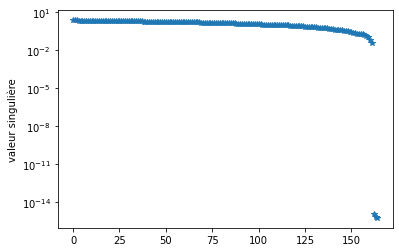

In [45]:
J = Jacobienne_K (U1,U2,U3, V1,V2,W , X,Y,THETA)
J_w = Jacobienne_w (U1,U2,U3, V1,V2,W , X,Y,THETA)
J_lambda = Jacobienne_lambda (U1,U2,U3, V1,V2,W , X,Y,THETA)

U, Eps , V = np.linalg.svd(J)

plt.plot(Eps,'*')
plt.yscale('log')
plt.ylabel("valeur singulière")

In [46]:
print("The rank of the matrice J_w is : ", np.linalg.matrix_rank(J_w) , "and his dimension is : ", J_w.shape)
print("The rank of the matrice J_lambda is  : ", np.linalg.matrix_rank(J_lambda) , "and his dimension is : ", J_lambda.shape)
print("The rank of the matrice J is : ", np.linalg.matrix_rank(J) , "and his dimension is : ", J.shape)

The rank of the matrice J_w is :  3 and his dimension is :  (225, 3)
The rank of the matrice J_lambda is  :  159 and his dimension is :  (225, 162)
The rank of the matrice J is :  162 and his dimension is :  (225, 165)


In [47]:
Q,R = np.linalg.qr(J_lambda)
b = np.zeros((R.shape[0],1))

In [48]:
Lambda = np.linalg.solve(R, b)
#Lambda == b

In [49]:
print(J.shape)
print(np.linalg.matrix_rank(J))

(225, 165)
162
